# **1.0 Initial Setup**

In [1]:
# Import the necessary libraries
import joblib # for saving and loading models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, KNNBasic, Reader, SVD
from surprise.accuracy import fcp, mae, mse, rmse # fcp = Fraction of Concordant Pairs
from surprise.model_selection import GridSearchCV, train_test_split

# Configurations
pd.set_option("display.max_colwidth", 100)
start_time = datetime.now()


# **2.0 Load Data**

## **2.1 Load Data for Content-Based Filtering**

In [2]:
# Load the skincare_reviews_cbf dataset
skincare_reviews_cbf = pd.read_feather("processed_data/skincare_reviews_cbf.feather")

# Display the shape of skincare_reviews_cbf
print(f"{skincare_reviews_cbf.shape[0]} rows and {skincare_reviews_cbf.shape[1]} columns")


51060 rows and 9 columns


In [3]:
# Display the first 5 rows of skincare_reviews_cbf
skincare_reviews_cbf.head().transpose()


,0,1,2,3,4
product_id,P503052,P423688,P504045,P479125,P440650
product_name,Mini Flatter Me Digestive Enzyme Supplement,Daily Microfoliant Exfoliator,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Mini Cloud Dew Oil-Free Gel Cream,Mini Retinol Youth Renewal Serum
brand_name,HUM Nutrition,Dermalogica,Supergoop!,Summer Fridays,Murad
average_rating,4.2643,4.696,4.7357,4.4613,4.6089
price_usd,15.0,65.0,46.0,17.0,32.0
author_id,27517179462,11109420515,22705593305,20430950197,5967382859
calibrated_author_rating,5.0,5.0,5.0,5.0,5.0
vectorized_features_glove,"[-0.1909807, 0.21728708, 0.063824415, -0.09881957, -0.1294178, 0.29103935, -0.16182004, 0.041187...","[-0.2007592, 0.18091148, 0.016441643, -0.12368103, -0.18935207, 0.16839498, -0.18683685, 0.11725...","[-0.19948438, 0.109405495, -0.016978933, -0.05321018, -0.23000163, 0.08242865, -0.09035488, 0.12...","[-0.16096152, 0.1353347, 0.0015462068, -0.03779596, -0.19740348, 0.16779856, -0.28631714, 0.2497...","[-0.22409232, 0.1372577, -0.024697045, -0.04310343, -0.15350178, 0.27084374, -0.07375035, 0.1545..."
vectorized_features_w2v,"[-0.025286864, 0.04773051, 0.00082256, 0.05296351, -0.11717987, 0.0034599304, 0.041460164, -0.15...","[-0.05279678, 0.100673035, 0.004677933, 0.080512166, -0.08585795, 0.025877278, 0.008998057, -0.1...","[-0.018925477, 0.11361898, 0.0039180755, 0.039836273, -0.077773795, 0.008910879, -0.0038208007, ...","[-0.0947309, 0.082422346, 0.046553873, 0.033076715, -0.15074053, -0.0037631989, -0.019455997, -0...","[-0.075490214, 0.063881546, 0.043978788, 0.03898683, -0.12316739, 0.017027408, -0.009806263, -0...."


## **2.2 Load Data for Collaborative Filtering**

In [4]:
# Load the skincare_reviews_cf dataset
skincare_reviews_cf = pd.read_feather("processed_data/skincare_reviews_cf.feather")

# Display the shape of skincare_reviews_cf
print(f"{skincare_reviews_cf.shape[0]} rows and {skincare_reviews_cf.shape[1]} columns")


51060 rows and 7 columns


In [5]:
# Display the first 5 rows of skincare_reviews_cf
skincare_reviews_cf.head().transpose()


,0,1,2,3,4
product_id,P503052,P423688,P504045,P479125,P440650
product_name,Mini Flatter Me Digestive Enzyme Supplement,Daily Microfoliant Exfoliator,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Mini Cloud Dew Oil-Free Gel Cream,Mini Retinol Youth Renewal Serum
brand_name,HUM Nutrition,Dermalogica,Supergoop!,Summer Fridays,Murad
average_rating,4.2643,4.696,4.7357,4.4613,4.6089
price_usd,15.0,65.0,46.0,17.0,32.0
author_id,27517179462,11109420515,22705593305,20430950197,5967382859
calibrated_author_rating,5.0,5.0,5.0,5.0,5.0


## **2.3 Author Profile Initialization**

In [6]:
# Set initial author profile
author_id = int("22705593305") # convert to integer
max_budget = 10000
top_n = 10


In [7]:
# Check if the author_id exists in the DataFrame
if author_id in skincare_reviews_cbf["author_id"].values:
    print(f"Author ID {author_id} is present in the DataFrame.")
else:
    print(f"Author ID {author_id} is not found in the DataFrame.")


Author ID 22705593305 is present in the DataFrame.


# **3.0 Content-Based Filtering Implementation**

In [8]:
# Function to plot the cumulative explained variance
def plot_explained_variance(svd_model, title="SVD Explained Variance",
                            xlabel="Number of Components",
                            ylabel="Cumulative Explained Variance"):
    plt.figure(figsize=(10, 6))
    variance = np.cumsum(svd_model.explained_variance_ratio_)
    plt.plot(variance, marker="o", label="Cumulative Variance")
    plt.xlabel(xlabel, fontweight="bold")
    plt.ylabel(ylabel, fontweight="bold")
    plt.title(title, fontweight="bold")
    plt.grid(True)
    plt.axhline(y=0.99, color="r", linestyle="--")
    plt.annotate("99% variance achieved", xy=(np.argmax(variance >= 0.99), 0.99),
                 xytext=(np.argmax(variance >= 0.99) + 10, 0.94),
                 textcoords="data", arrowprops=dict(facecolor="black", arrowstyle="->"),
                 horizontalalignment="right", verticalalignment="top")
    plt.show()
    

## **3.1 Calculating Cosine Similarity via GloVe Word Embedding**

In [9]:
# Stack all feature vectors into a matrix for cosine similarity computation
features_matrix_glove = np.stack(skincare_reviews_cbf["vectorized_features_glove"].values)

# Display the shape of features_matrix_glove
print(f"{features_matrix_glove.shape[0]} rows and {features_matrix_glove.shape[1]} columns")


51060 rows and 300 columns


In [10]:
# Check the memory usage of features_matrix_glove
print(f"Memory usage of features_matrix_glove: {features_matrix_glove.nbytes / 1024**2:.2f} MB")


Memory usage of features_matrix_glove: 58.43 MB


In [11]:
# Fit SVD on the features_matrix_glove (n_components = the number of latent factors)
svd_glove = TruncatedSVD(n_components=300) # set to the maximum value of 300 for the best performance
reduced_matrix_glove = svd_glove.fit_transform(features_matrix_glove)


In [12]:
# Delete the original features_matrix_glove to free up memory
del features_matrix_glove


In [13]:
# Compute cosine similarity on the reduced_matrix_glove
cosine_sim_glove = cosine_similarity(reduced_matrix_glove)


In [14]:
# Check the data types of cosine similarity matrix with GloVe embeddings
print(f"Cosine similarity matrix data type: {cosine_sim_glove.dtype}")


Cosine similarity matrix data type: float32


In [15]:
# Check the memory usage of the cosine similarity matrix
print(f"Memory usage of cosine_sim: {cosine_sim_glove.nbytes / 1024**3:.3f} GB")


Memory usage of cosine_sim: 9.712 GB


In [16]:
# Display the first 5 rows of the cosine similarity matrix
print(cosine_sim_glove[:5, :5])


[[0.9999997  0.8063826  0.76664734 0.78524506 0.7372864 ]
 [0.8063826  0.9999998  0.94207144 0.90404254 0.90903455]
 [0.76664734 0.94207144 1.0000004  0.899597   0.91841334]
 [0.78524506 0.90404254 0.899597   0.9999994  0.9509821 ]
 [0.7372864  0.90903455 0.91841334 0.9509821  0.9999994 ]]


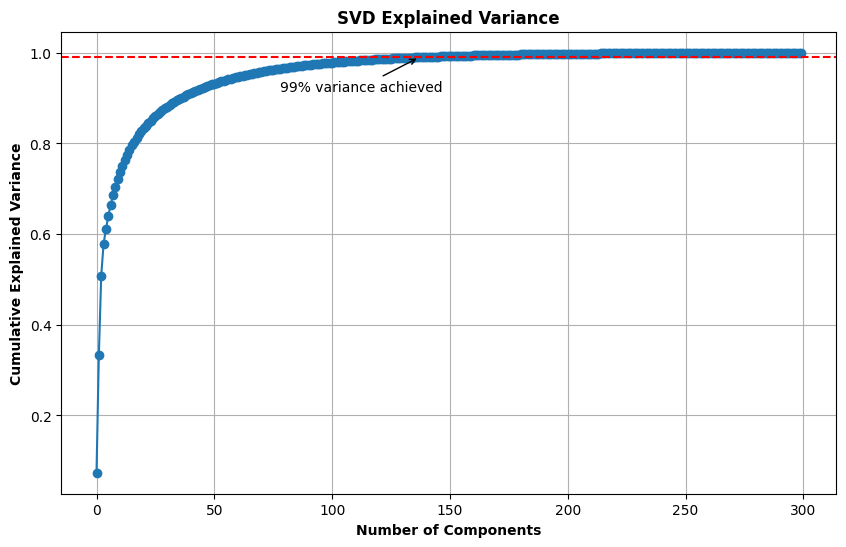

In [17]:
# Plot the cumulative explained variance
plot_explained_variance(svd_glove)


In [18]:
# # Save the cosine similarity matrix to a NumPy array (npy) file before deletion
# np.save("deployment/cosine_sim_matrix_glove.npy", cosine_sim_glove)


In [19]:
# Delete the reduced matrix and cosine similarity matrix to free up memory
del reduced_matrix_glove, cosine_sim_glove


In [20]:
# Function to perform content-based filtering recommendations using GloVe embeddings
def get_cbf_glove_recommendations(author_id, top_n, max_budget):
    # Retrieve all reviews by the specified author from the skincare_reviews dataset
    author_reviews = skincare_reviews_cbf.query("author_id == @author_id")
    
    # Return error message if no reviews are found for the author
    if author_reviews.empty:
        return f"Author {author_id} is not found! Please try another author."
    
    # Calculate the author's average profile from their reviewed product feature vectors
    author_profile = np.mean(np.stack(author_reviews["vectorized_features_glove"].values), axis=0)

    # Select products not reviewed by the author and within the specified budget
    filtered_products = skincare_reviews_cbf.loc[
        (~skincare_reviews_cbf["product_id"].isin(author_reviews["product_id"])) &
        (skincare_reviews_cbf["price_usd"] <= max_budget)
    ].copy()
    
    # Return error message if no products are found within the budget
    if filtered_products.empty:
        return f"No products found within budget of ${max_budget}. Try increasing the budget."
    
    # Compute similarity scores
    filtered_products["similarity_score"] = cosine_similarity(
        [author_profile],
        np.stack(filtered_products["vectorized_features_glove"].values)
    )[0]
    
    # Get the top N recommendations
    final_recommendations = filtered_products.query("similarity_score < 1").sort_values(
        by="similarity_score", ascending=False
    ).drop_duplicates(subset="product_id").head(top_n)[
        ["product_id", "product_name", "brand_name", "price_usd", "average_rating", "similarity_score"]
    ]
    
    return final_recommendations.reset_index(drop=True)


In [21]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cbf[skincare_reviews_cbf["author_id"] == author_id][["product_id",
                                                                              "product_name",
                                                                              "brand_name",
                                                                              "price_usd",
                                                                              "average_rating"]])

# Generate content-based filtering recommendations using GloVe embeddings
print(f"\nGenerating top {top_n} recommendations using content-based filtering with GloVe embeddings...")
display(get_cbf_glove_recommendations(author_id, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,average_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,4.7357
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.3750
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,4.4315
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,4.4375
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.7260
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.6795
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,4.8839
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,4.5405
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,4.4985
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.7705



Generating top 10 recommendations using content-based filtering with GloVe embeddings...


,product_id,product_name,brand_name,price_usd,average_rating,similarity_score
0,P479313,Advanced Retinol + Ferulic Intense Wrinkle Cream,Dr. Dennis Gross Skincare,77.0,4.6950,0.988384
1,P475159,Evercalm Redness Relief Serum,REN Clean Skincare,60.0,4.3985,0.985890
2,P475186,Revive + Rewind Revitalizing Eye Cream,TULA Skincare,52.0,4.2391,0.985679
3,P501243,GOOPGLOW Exfoliating Dark Spot Sleep Serum,goop,98.0,4.0598,0.984818
4,P502322,The Healthy Skin Edit Bestsellers Kit,iNNBEAUTY PROJECT,36.0,4.7849,0.984489
5,P270600,Extra Eye Repair Cream Intense,Bobbi Brown,86.0,3.3636,0.984042
6,P475180,On The Go Best Sellers Travel Kit,TULA Skincare,49.0,4.2366,0.983991
7,P461165,GOOPGENES All-In-One Nourishing Eye Cream,goop,55.0,4.2026,0.983948
8,P434546,Goodnight Glow Bakuchiol Sleeping Crème,OLEHENRIKSEN,60.0,3.8817,0.983164
9,P460624,Discover Healthy Skin Kit,Dermalogica,39.5,4.6265,0.983019


## **3.2 Calculating Cosine Similarity via Word2Vec Word Embedding**

In [22]:
# Stack all feature vectors into a matrix for cosine similarity computation
features_matrix_w2v = np.stack(skincare_reviews_cbf["vectorized_features_w2v"].values)

# Display the shape of features_matrix_w2v
print(f"{features_matrix_w2v.shape[0]} rows and {features_matrix_w2v.shape[1]} columns")


51060 rows and 300 columns


In [23]:
# Check the memory usage of features_matrix_w2v
print(f"Memory usage of features_matrix_w2v: {features_matrix_w2v.nbytes / 1024**2:.2f} MB")


Memory usage of features_matrix_w2v: 58.43 MB


In [24]:
# Fit SVD on the features_matrix_w2v
svd_w2v = TruncatedSVD(n_components=300)
reduced_matrix_w2v = svd_w2v.fit_transform(features_matrix_w2v)


In [25]:
# Delete the original features_matrix_w2v to free up memory
del features_matrix_w2v


In [26]:
# Compute cosine similarity on the reduced_matrix_w2v
cosine_sim_w2v = cosine_similarity(reduced_matrix_w2v)


In [27]:
# Check the data types of cosine similarity matrix with Word2Vec embeddings
print(f"Cosine similarity matrix data type: {cosine_sim_w2v.dtype}")


Cosine similarity matrix data type: float32


In [28]:
# Check the memory usage of the cosine similarity matrix
print(f"Memory usage of cosine_sim: {cosine_sim_w2v.nbytes / 1024**3:.3f} GB")


Memory usage of cosine_sim: 9.712 GB


In [29]:
# Display the first 5 rows of the cosine similarity matrix
print(cosine_sim_w2v[:5, :5])


[[0.9999993  0.87584066 0.8621205  0.8842362  0.88541794]
 [0.87584066 0.9999999  0.9361285  0.91816235 0.904307  ]
 [0.8621205  0.9361285  0.99999994 0.91000843 0.91027933]
 [0.8842362  0.91816235 0.91000843 1.0000005  0.9673917 ]
 [0.88541794 0.904307   0.91027933 0.9673917  0.9999996 ]]


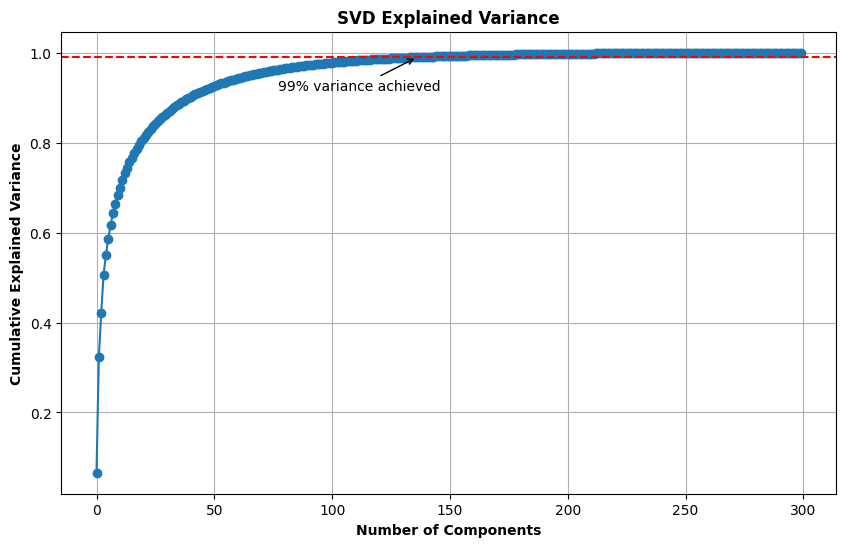

In [30]:
# Plot the cumulative explained variance
plot_explained_variance(svd_w2v)


In [31]:
# # Save the cosine similarity matrix to a NumPy array (npy) file before deletion
# np.save("deployment/cosine_sim_matrix_w2v.npy", cosine_sim_w2v)


In [32]:
# Delete the reduced matrix and cosine similarity matrix to free up memory
del reduced_matrix_w2v, cosine_sim_w2v


In [33]:
# Function to perform content-based filtering recommendations using Word2Vec embeddings
def get_cbf_w2v_recommendations(author_id, top_n, max_budget):
    # Retrieve all reviews by the specified author from the skincare_reviews dataset
    author_reviews = skincare_reviews_cbf.query("author_id == @author_id")
    
    # Return error message if no reviews are found for the author
    if author_reviews.empty:
        return f"Author {author_id} is not found! Please try another author."
    
    # Calculate the author's average profile from their reviewed product feature vectors
    author_profile = np.mean(np.stack(author_reviews["vectorized_features_w2v"].values), axis=0)

    # Select products not reviewed by the author and within the specified budget
    filtered_products = skincare_reviews_cbf.loc[
        (~skincare_reviews_cbf["product_id"].isin(author_reviews["product_id"])) &
        (skincare_reviews_cbf["price_usd"] <= max_budget)
    ].copy()
    
    # Return error message if no products are found within the budget
    if filtered_products.empty:
        return f"No products found within budget of ${max_budget}. Try increasing the budget."
    
    # Compute similarity scores
    filtered_products["similarity_score"] = cosine_similarity(
        [author_profile],
        np.stack(filtered_products["vectorized_features_w2v"].values)
    )[0]

    # Get the top N recommendations
    final_recommendations = filtered_products.query("similarity_score < 1").sort_values(
        by="similarity_score", ascending=False
    ).drop_duplicates(subset="product_id").head(top_n)[
        ["product_id", "product_name", "brand_name", "price_usd", "average_rating", "similarity_score"]
    ]
    
    return final_recommendations.reset_index(drop=True)


In [34]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cbf[skincare_reviews_cbf["author_id"] == author_id][["product_id",
                                                                              "product_name",
                                                                              "brand_name",
                                                                              "price_usd",
                                                                              "average_rating"]])

# Generate content-based filtering recommendations using Word2Vec embeddings
print(f"\nGenerating top {top_n} recommendations using content-based filtering with Word2Vec embeddings...")
display(get_cbf_w2v_recommendations(author_id, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,average_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,4.7357
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.3750
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,4.4315
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,4.4375
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.7260
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.6795
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,4.8839
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,4.5405
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,4.4985
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.7705



Generating top 10 recommendations using content-based filtering with Word2Vec embeddings...


,product_id,product_name,brand_name,price_usd,average_rating,similarity_score
0,P502322,The Healthy Skin Edit Bestsellers Kit,iNNBEAUTY PROJECT,36.0,4.7849,0.987249
1,P472810,Smart Response Serum,Dermalogica,145.0,4.7825,0.987059
2,P460624,Discover Healthy Skin Kit,Dermalogica,39.5,4.6265,0.986838
3,P435975,Mini Charlotte's Magic Cream,Charlotte Tilbury,30.0,3.6585,0.986773
4,P433520,Magic Cream Moisturizer with Hyaluronic Acid,Charlotte Tilbury,100.0,4.4045,0.986531
5,P480192,Light Aura Vitamin C + Peptide Eye Cream,Summer Fridays,42.0,4.3596,0.986324
6,P504240,Mini Instant Reset Brightening Overnight Recovery Gel-Cream With Niacinamide + Kalahari Melon Oil,Fenty Skin,26.0,4.1988,0.985979
7,P467250,Instant Reset Brightening Overnight Recovery Gel-Cream With Niacinamide + Kalahari Melon Oil,Fenty Skin,45.0,4.1988,0.985979
8,P457695,DeliKate Recovery Cream,Kate Somerville,76.0,4.4971,0.985970
9,P475124,The Hydrating Infused Emulsion,La Mer,125.0,4.6222,0.985894


# **4.0 Collaborative Filtering Implementation**

## **4.1 Singular Value Decomposition (SVD) Model**

### **4.1.1 Initial SVD Model**

In [35]:
# Load and prepare data for initial SVD model
svd_data = Dataset.load_from_df(skincare_reviews_cf[["author_id",
                                                     "product_id",
                                                     "calibrated_author_rating"]],
                                Reader(rating_scale=(1, 5)))

# Split the data into training and testing sets
svd_trainset, svd_testset = train_test_split(svd_data, test_size=0.2, random_state=42)


In [36]:
# Build and train the initial SVD model
svd_model = SVD()
svd_model.fit(svd_trainset)


In [37]:
# Evaluate the initial SVD model
svd_initial_predictions = svd_model.test(svd_testset)

# Calculate the evaluation metrics for the initial SVD model
svd_initial_rmse = rmse(svd_initial_predictions, verbose=False)
svd_initial_mae = mae(svd_initial_predictions, verbose=False)
svd_initial_mse = mse(svd_initial_predictions, verbose=False)
svd_initial_fcp = fcp(svd_initial_predictions, verbose=False)

# Print the evaluation results for the initial SVD model
print("Initial SVD Model Evaluation:")
print("-----------------------------")
print(f"Root Mean Squared Error (RMSE): {svd_initial_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {svd_initial_mae:.4f}")
print(f"Mean Squared Error (MSE): {svd_initial_mse:.4f}")
print(f"Fraction of Concordant Pairs (FCP): {svd_initial_fcp:.4f}")


Initial SVD Model Evaluation:
-----------------------------
Root Mean Squared Error (RMSE): 0.5565
Mean Absolute Error (MAE): 0.3071
Mean Squared Error (MSE): 0.3096
Fraction of Concordant Pairs (FCP): 0.5244


In [38]:
# Prepare a deduplicated product details DataFrame for efficient merging
product_details = skincare_reviews_cf.drop_duplicates(subset="product_id")[["product_id",
                                                                            "product_name",
                                                                            "brand_name",
                                                                            "price_usd"]]
product_price = product_details.set_index("product_id")["price_usd"].to_dict()


In [39]:
# Function to perform collaborative filtering recommendations using SVD model
def get_cf_svd_recommendations(author_id, svd_model, top_n, max_budget):
    # Check if the author exists in the trainset
    try:
        inner_author_id = svd_trainset.to_inner_uid(author_id)
    except ValueError:
        return f"Author {author_id} is not found! Please try another author."
    
    # Get all products and the products rated by the author
    all_products = set(skincare_reviews_cf["product_id"].unique())
    rated_products = set(skincare_reviews_cf.query("author_id == @author_id and calibrated_author_rating > 0")["product_id"].unique())
    
    # Determine unrated products
    unrated_products = all_products - rated_products

    # Pre-filter products within the budget to reduce unnecessary predictions
    affordable_unrated_products = {prod for prod in unrated_products if product_price.get(prod, float("inf")) <= max_budget}

    # Predict ratings for the affordable unrated items
    predictions = [svd_model.predict(author_id, prod, clip=True) for prod in affordable_unrated_products]
    
    # Check if there are any predictions
    if not predictions:
        return f"No products found within budget of ${max_budget}. Try increasing the budget."

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Build the final recommendations DataFrame
    top_recs = pd.DataFrame([(pred.iid, pred.est) for pred in predictions[:top_n]], columns=["product_id", "predicted_rating"])
    
    # Merge with product details
    final_recommendations = top_recs.merge(product_details, on="product_id", how="left").head(top_n)
    
    # Reset the index and return the final recommendations
    return final_recommendations[["product_id", "product_name", "brand_name", "price_usd", "predicted_rating"]].reset_index(drop=True)


In [40]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cf.query("author_id == @author_id")[["product_id",
                                                              "product_name",
                                                              "brand_name",
                                                              "price_usd",
                                                              "calibrated_author_rating"]])

# Generate collaborative filtering recommendations using the SVD model
print(f"\nGenerating top {top_n} recommendations using the SVD model...")
display(get_cf_svd_recommendations(author_id, svd_model, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,calibrated_author_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,5.0
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.5
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,5.0
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,5.0
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.5
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.5
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,5.0
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,5.0
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,5.0
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.5



Generating top 10 recommendations using the SVD model...


,product_id,product_name,brand_name,price_usd,predicted_rating
0,P377570,Argan Infinity Cream Intensive Creamy Oil,Josie Maran,28.0,4.870200
1,P427413,Lactic Acid 10% + HA 2% Exfoliating Serum,The Ordinary,8.9,4.868133
2,P503250,Watch Ya Tone 5% Niacinamide Dark Spot Serum with Vitamin C,Fenty Skin,42.0,4.828431
3,P469528,Skin Perfecting 25% AHA + 2% BHA Exfoliant Peel,Paula's Choice,42.0,4.825784
4,P417936,Rose & Hyaluronic Acid Deep Hydration Toner,fresh,46.0,4.766246
5,P419466,Tan Build Up Remover Mitt,St. Tropez,9.0,4.764333
6,P503657,Premier Cru Skin Barrier Rich Moisturizer with Bio-Ceramides,Caudalie,129.0,4.760836
7,P467750,Resveratrol Lift Retinol Alternative Firming Cashmere Moisturizer,Caudalie,69.0,4.752555
8,P415747,Brazilian Kiss Cupuaçu Lip Butter,Sol de Janeiro,18.0,4.746283
9,P504506,The Silk Serum Wrinkle-Smoothing Retinol Alternative,Tatcha,98.0,4.739862


### **4.1.2 Optimized SVD Model via Hyperparameter Tuning**

**Default Parameters of `SVD()`:**

1. **lr_all**: 0.005 - The learning rate for all parameters.
2. **n_epochs**: 20 - The number of iteration of the stochastic gradient descent (SGD) procedure.
3. **n_factors**: 100 - The number of latent factors to use.
4. **reg_all**: 0.02 - The regularization term for all parameters.

In [41]:
# Define a range of hyperparameters for the SVD model
svd_param_grid = {
    "lr_all": [0.005, 0.01, 0.02, 0.03, 0.05],
    "n_epochs": [30, 50],
    "n_factors": [10, 50, 100, 150, 200, 250],
    "reg_all": [0.02, 0.05, 0.1, 0.2]
}


In [42]:
# Perform grid search with cross-validation for the SVD model
gs_svd = GridSearchCV(SVD, svd_param_grid, measures=["rmse", "mae", "mse", "fcp"],
                      cv=5, n_jobs=-1, joblib_verbose=5)

# Fit the grid search on the data
gs_svd.fit(svd_data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.5min finished


In [43]:
# Print the evaluation results for the optimized SVD model
print("Optimized SVD Model Evaluation:")
print("-------------------------------")
print(f"Best Root Mean Squared Error (RMSE): {gs_svd.best_score['rmse']:.4f}")
print(f"Best Mean Absolute Error (MAE): {gs_svd.best_score['mae']:.4f}")
print(f"Best Mean Squared Error (MSE): {gs_svd.best_score['mse']:.4f}")
print(f"Best Fraction of Concordant Pairs (FCP): {gs_svd.best_score['fcp']:.4f}")

# Function to print the best parameters for the SVD model
def print_params_svd(title, params):
    print(title)
    counter = 1
    for key, value in params.items():
        print(f"{counter}. {key} = {value}")
        counter += 1

# Print the best parameters for the SVD model
print_params_svd("\nParameters for best RMSE:", gs_svd.best_params["rmse"])
print_params_svd("\nParameters for best MAE:", gs_svd.best_params["mae"])
print_params_svd("\nParameters for best MSE:", gs_svd.best_params["mse"])
print_params_svd("\nParameters for best FCP:", gs_svd.best_params["fcp"])


Optimized SVD Model Evaluation:
-------------------------------
Best Root Mean Squared Error (RMSE): 0.5309
Best Mean Absolute Error (MAE): 0.2800
Best Mean Squared Error (MSE): 0.2819
Best Fraction of Concordant Pairs (FCP): 0.5753

Parameters for best RMSE:
1. lr_all = 0.03
2. n_epochs = 50
3. n_factors = 200
4. reg_all = 0.05

Parameters for best MAE:
1. lr_all = 0.05
2. n_epochs = 50
3. n_factors = 250
4. reg_all = 0.02

Parameters for best MSE:
1. lr_all = 0.03
2. n_epochs = 50
3. n_factors = 200
4. reg_all = 0.05

Parameters for best FCP:
1. lr_all = 0.03
2. n_epochs = 50
3. n_factors = 200
4. reg_all = 0.05


In [44]:
# Re-train and evaluate the SVD model with optimized parameters
optimized_svd_model = gs_svd.best_estimator["rmse"]
optimized_svd_model.fit(svd_trainset)


In [45]:
# Evaluate the optimized SVD model
svd_optimized_predictions = optimized_svd_model.test(svd_testset)

# Calculate metrics for the optimized model
svd_optimized_rmse = rmse(svd_optimized_predictions, verbose=False)
svd_optimized_mae = mae(svd_optimized_predictions, verbose=False)
svd_optimized_mse = mse(svd_optimized_predictions, verbose=False)
svd_optimized_fcp = fcp(svd_optimized_predictions, verbose=False)

# Print the evaluation results for the optimized SVD model after tuning
print("Optimized SVD Model Evaluation (Post-Tuning):")
print("---------------------------------------------")
print(f"Root Mean Squared Error (RMSE): {svd_optimized_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {svd_optimized_mae:.4f}")
print(f"Mean Squared Error (MSE): {svd_optimized_mse:.4f}")
print(f"Fraction of Concordant Pairs (FCP): {svd_optimized_fcp:.4f}")


Optimized SVD Model Evaluation (Post-Tuning):
---------------------------------------------
Root Mean Squared Error (RMSE): 0.5332
Mean Absolute Error (MAE): 0.2844
Mean Squared Error (MSE): 0.2843
Fraction of Concordant Pairs (FCP): 0.5689


In [46]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cf.query("author_id == @author_id")[["product_id",
                                                              "product_name",
                                                              "brand_name",
                                                              "price_usd",
                                                              "calibrated_author_rating"]])

# Generate collaborative filtering recommendations using the best SVD model
print(f"\nGenerating top {top_n} recommendations using the best SVD model...")
display(get_cf_svd_recommendations(author_id, optimized_svd_model, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,calibrated_author_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,5.0
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.5
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,5.0
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,5.0
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.5
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.5
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,5.0
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,5.0
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,5.0
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.5



Generating top 10 recommendations using the best SVD model...


,product_id,product_name,brand_name,price_usd,predicted_rating
0,P415747,Brazilian Kiss Cupuaçu Lip Butter,Sol de Janeiro,18.0,5
1,P479903,Mini Phoenix Rosehip Anti-Aging Face Oil - For Dry Skin,Herbivore,60.0,5
2,P504919,Milky Oil Dual-Phase Waterproof Makeup Remover,Glossier,14.0,5
3,P468637,Vinoclean Makeup Removing Cleansing Oil,Caudalie,30.0,5
4,P503901,Hydration Heroes Green Tea Skincare Routine Set,innisfree,39.0,5
5,P188306,Acne Solutions All-Over Clearing Treatment Oil-Free,CLINIQUE,26.0,5
6,P475589,Ginzing Vitamin C Eye Cream to Brighten and Depuff,Origins,37.0,5
7,P397623,Dermask Water Jet Vital Hydra Solution,Dr. Jart+,7.0,5
8,P173726,Facial Cotton,Shiseido,13.0,5
9,P469818,Cactus Water Cleansing Lactic Acid Toner,Freck Beauty,32.0,5


### **4.1.3 Comparison Table of Initial and Optimized SVD Models**

In [47]:
# Create a DataFrame to display the SVM model comparison results
svd_comparison = pd.DataFrame({
    "Metrics": ["RMSE", "MAE", "MSE", "FCP"],
    "Initial SVD Model": [svd_initial_rmse, svd_initial_mae, svd_initial_mse, svd_initial_fcp],
    "Optimized SVD Model": [svd_optimized_rmse, svd_optimized_mae, svd_optimized_mse, svd_optimized_fcp]
})

# Display the SVD model comparison results
svd_comparison.set_index("Metrics", inplace=True)
display(svd_comparison.map(lambda x: f"{x:.4f}").transpose())


Metrics,RMSE,MAE,MSE,FCP
Initial SVD Model,0.5565,0.3071,0.3096,0.5244
Optimized SVD Model,0.5332,0.2844,0.2843,0.5689


## **4.2 K-Nearest Neighbors (KNN) Model**

### **4.2.1 Initial KNN Model**

In [48]:
# Load and prepare data for initial KNN model
knn_data = Dataset.load_from_df(skincare_reviews_cf[["author_id",
                                                     "product_id",
                                                     "calibrated_author_rating"]],
                                Reader(rating_scale=(1, 5)))

# Split the data into training and testing sets
knn_trainset, knn_testset = train_test_split(knn_data, test_size=0.2, random_state=42)


In [49]:
# Build and train the initial KNN model
knn_model = KNNBasic()
knn_model.fit(knn_trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [50]:
# Evaluate the initial KNN model
knn_initial_predictions = knn_model.test(knn_testset)

# Calculate the evaluation metrics for the initial KNN model
knn_initial_rmse = rmse(knn_initial_predictions, verbose=False)
knn_initial_mae = mae(knn_initial_predictions, verbose=False)
knn_initial_mse = mse(knn_initial_predictions, verbose=False)
knn_initial_fcp = fcp(knn_initial_predictions, verbose=False)

# Print the evaluation results for the initial KNN model
print("Initial KNN Model Evaluation:")
print("-----------------------------")
print(f"Root Mean Squared Error (RMSE): {knn_initial_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {knn_initial_mae:.4f}")
print(f"Mean Squared Error (MSE): {knn_initial_mse:.4f}")
print(f"Fraction of Concordant Pairs (FCP): {knn_initial_fcp:.4f}")


Initial KNN Model Evaluation:
-----------------------------
Root Mean Squared Error (RMSE): 0.6223
Mean Absolute Error (MAE): 0.3076
Mean Squared Error (MSE): 0.3872
Fraction of Concordant Pairs (FCP): 0.5576


In [51]:
# Function to perform collaborative filtering recommendations using KNN model
def get_cf_knn_recommendations(author_id, knn_model, top_n, max_budget):
    # Check if the author exists in the trainset
    try:
        inner_author_id = knn_trainset.to_inner_uid(author_id)
    except ValueError:
        return f"Author {author_id} is not found! Please try another author."

    # Get all products and the products rated by the author
    all_products = set(skincare_reviews_cf["product_id"].unique())
    rated_products = set(skincare_reviews_cf.query("author_id == @author_id and calibrated_author_rating > 0")["product_id"].unique())

    # Determine unrated products
    unrated_products = all_products - rated_products

    # Pre-filter products within the budget to reduce unnecessary predictions
    affordable_unrated_products = {prod for prod in unrated_products if product_price.get(prod, float("inf")) <= max_budget}

    # Predict ratings for the affordable unrated items
    predictions = [knn_model.predict(author_id, prod, clip=True) for prod in affordable_unrated_products]

    # Check if there are any predictions
    if not predictions:
        return f"No products found within budget of ${max_budget}. Try increasing the budget."

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Build the final recommendations DataFrame
    top_recs = pd.DataFrame([(pred.iid, pred.est) for pred in predictions[:top_n]], columns=["product_id", "predicted_rating"])
    
    # Merge with product details
    final_recommendations = top_recs.merge(product_details, on="product_id", how="left").head(top_n)
    
    # Reset the index and return the final recommendations
    return final_recommendations[["product_id", "product_name", "brand_name", "price_usd", "predicted_rating"]].reset_index(drop=True)


In [52]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cf.query("author_id == @author_id")[["product_id",
                                                              "product_name",
                                                              "brand_name",
                                                              "price_usd",
                                                              "calibrated_author_rating"]])

# Generate collaborative filtering recommendations using the KNN model
print(f"\nGenerating top {top_n} recommendations using the KNN model...")
display(get_cf_knn_recommendations(author_id, knn_model, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,calibrated_author_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,5.0
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.5
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,5.0
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,5.0
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.5
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.5
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,5.0
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,5.0
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,5.0
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.5



Generating top 10 recommendations using the KNN model...


,product_id,product_name,brand_name,price_usd,predicted_rating
0,P474825,Advanced Retinol + Ferulic Triple Correction Eye Serum,Dr. Dennis Gross Skincare,71.0,5
1,P503262,Peel and Plump Skin-Smoothing Duo,alpyn beauty,49.0,5
2,P500428,Lift & Contour 1% Bakuchiol & Peptide Eye Serum,Wishful,45.0,5
3,P479903,Mini Phoenix Rosehip Anti-Aging Face Oil - For Dry Skin,Herbivore,60.0,5
4,P460723,Clean Cleansing & Gentle Exfoliating Wipes,SEPHORA COLLECTION,6.0,5
5,P476414,5 Stars Retinol + Niacinamide Eye Serum,Sunday Riley,65.0,5
6,P464288,Sephora City Reusable Water Bottle,SEPHORA COLLECTION,8.0,5
7,P442748,Hydrating Floral Mask,Tata Harper,95.0,5
8,P482328,Mini Natural Moisturizing Factors + HA,The Ordinary,6.5,5
9,P481703,Black Tea Corset Cream Firming Moisturizer,fresh,95.0,5


### **4.2.2 Optimized KNN Model via Hyperparameter Tuning**

**Default Parameters of `KNNBasic()`:**

1. **k**: 40 - The maximum number of neighbors to consider for aggregation.
2. **min_k**: 1 - The minimum number of neighbors to consider for aggregation.
3. **sim_options**:
    - **min_support**: 1 - The minimum number of common items (or users, depending on whether it's item-based or user-based) required for not considering similarity as zero.
    - **name**: "msd" - The default similarity measure (Mean Squared Difference).
    - **user_based**: True - Indicates user-based collaborative filtering and False means item-based collaborative filtering.

In [53]:
# Define a range of hyperparameters for the KNN model
knn_param_grid = {
    "k": [10, 20, 30, 40, 50],
    "min_k": [1, 2, 3],
    "sim_options": {
        "min_support": [1, 2, 3],
        "name": ["msd", "cosine", "pearson", "pearson_baseline"],
        "user_based": [True, False]
    }
}


In [54]:
# Perform grid search with cross-validation for the KNN model
gs_knn = GridSearchCV(KNNBasic, knn_param_grid, measures=["rmse", "mae", "mse", "fcp"],
                      cv=5, n_jobs=-1, joblib_verbose=5)

# Fit the grid search on the data
gs_knn.fit(knn_data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  3.8min finished


In [55]:
# Print the evaluation results for the optimized KNN model
print("Optimized KNN Model Evaluation:")
print("-------------------------------")
print(f"Best Root Mean Squared Error (RMSE): {gs_knn.best_score['rmse']:.4f}")
print(f"Best Mean Absolute Error (MAE): {gs_knn.best_score['mae']:.4f}")
print(f"Best Mean Squared Error (MSE): {(gs_knn.best_score['rmse'])**2:.4f}")
print(f"Best Fraction of Concordant Pairs (FCP): {gs_knn.best_score['fcp']:.4f}")

# Function to print the best parameters for the KNN model
def print_params_knn(title, params):
    print(title)
    for index, (key, value) in enumerate(params.items(), start=1):
        if isinstance(value, dict):
            print(f"{index}. {key}")
            for subkey, subvalue in value.items():
                print(f"   - {subkey} = {subvalue}")
        else:
            print(f"{index}. {key} = {value}")

# Print the best parameters for the KNN model
print_params_knn("\nParameters for best RMSE:", gs_knn.best_params["rmse"])
print_params_knn("\nParameters for best MAE:", gs_knn.best_params["mae"])
print_params_knn("\nParameters for best MSE:", gs_knn.best_params["mse"])
print_params_knn("\nParameters for best FCP:", gs_knn.best_params["fcp"])


Optimized KNN Model Evaluation:
-------------------------------
Best Root Mean Squared Error (RMSE): 0.5746
Best Mean Absolute Error (MAE): 0.2678
Best Mean Squared Error (MSE): 0.3301
Best Fraction of Concordant Pairs (FCP): 0.5729

Parameters for best RMSE:
1. k = 50
2. min_k = 1
3. sim_options
   - min_support = 1
   - name = msd
   - user_based = False

Parameters for best MAE:
1. k = 10
2. min_k = 1
3. sim_options
   - min_support = 1
   - name = pearson_baseline
   - user_based = False

Parameters for best MSE:
1. k = 50
2. min_k = 1
3. sim_options
   - min_support = 1
   - name = msd
   - user_based = False

Parameters for best FCP:
1. k = 40
2. min_k = 1
3. sim_options
   - min_support = 1
   - name = msd
   - user_based = True


In [56]:
# Re-train and evaluate the KNN model with optimized parameters
optimized_knn_model = gs_knn.best_estimator["rmse"]
optimized_knn_model.fit(knn_trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [57]:
# Evaluate the optimized KNN model
knn_optimized_predictions = optimized_knn_model.test(knn_testset)

# Calculate metrics for the optimized model
knn_optimized_rmse = rmse(knn_optimized_predictions, verbose=False)
knn_optimized_mae = mae(knn_optimized_predictions, verbose=False)
knn_optimized_mse = mse(knn_optimized_predictions, verbose=False)
knn_optimized_fcp = fcp(knn_optimized_predictions, verbose=False)

# Print the evaluation results for the optimized KNN model after tuning
print("Optimized KNN Model Evaluation (Post-Tuning):")
print("---------------------------------------------")
print(f"Root Mean Squared Error (RMSE): {knn_optimized_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {knn_optimized_mae:.4f}")
print(f"Mean Squared Error (MSE): {knn_optimized_mse:.4f}")
print(f"Fraction of Concordant Pairs (FCP): {knn_optimized_fcp:.4f}")

Optimized KNN Model Evaluation (Post-Tuning):
---------------------------------------------
Root Mean Squared Error (RMSE): 0.5739
Mean Absolute Error (MAE): 0.2868
Mean Squared Error (MSE): 0.3293
Fraction of Concordant Pairs (FCP): 0.5110


In [58]:
# Display the author's reviewed products
print(f"Author {author_id} reviewed the following product(s):")
display(skincare_reviews_cf.query("author_id == @author_id")[["product_id",
                                                              "product_name",
                                                              "brand_name",
                                                              "price_usd",
                                                              "calibrated_author_rating"]])

# Generate collaborative filtering recommendations using the best KNN model
print(f"\nGenerating top {top_n} recommendations using the best KNN model...")
display(get_cf_knn_recommendations(author_id, optimized_knn_model, top_n, max_budget))


Author 22705593305 reviewed the following product(s):


,product_id,product_name,brand_name,price_usd,calibrated_author_rating
2,P504045,Daily Dose Bioretinol + Mineral SPF 40 with Bakuchiol,Supergoop!,46.0,5.0
7776,P438619,Brightening Eye Cream with Caffeine and Hyaluronic Acid,SEPHORA COLLECTION,18.0,4.5
8205,P482676,10% Waterless Vitamin C Serum,Farmacy,50.0,5.0
9113,P232915,ExfoliKate Intensive Pore Exfoliating Treatment,Kate Somerville,98.0,5.0
11718,P503726,B3 Nice 10% Niacinamide Serum,Sunday Riley,65.0,4.5
12051,P501254,Watermelon Glow AHA Night Treatment,Glow Recipe,40.0,4.5
14443,P503992,Chia + Moringa Algae Enzyme Cleansing Oil,MARA,58.0,5.0
14808,P483643,Willow & Sweet Agave Plumping Lip Mask,alpyn beauty,28.0,5.0
15955,P471046,Turmeric Glow Brightening Moisturizer,KORA Organics,62.0,5.0
16634,P504076,Exfoliating Revitalizing & Energizing Caffeine Micro Polish,The Outset,34.0,4.5



Generating top 10 recommendations using the best KNN model...


,product_id,product_name,brand_name,price_usd,predicted_rating
0,P462339,Vitamin Enriched Eye Base,Bobbi Brown,58.00,5
1,P479903,Mini Phoenix Rosehip Anti-Aging Face Oil - For Dry Skin,Herbivore,60.00,5
2,P467945,Capture Totale Super Potent Rich Cream,Dior,130.00,5
3,P418629,C.E.O. Vitamin C Brightening Rich Hydration Moisturizer,Sunday Riley,22.00,5
4,P476414,5 Stars Retinol + Niacinamide Eye Serum,Sunday Riley,65.00,5
5,P442748,Hydrating Floral Mask,Tata Harper,95.00,5
6,P387261,Pumpkin Enzyme Mask Enzymatic Dermal Resurfacer,Peter Thomas Roth,60.00,5
7,P433617,Deep Cleansing Foam,Shiseido,36.00,5
8,P443842,Retinol Anti-Aging Serum,The INKEY List,12.99,5
9,P447785,Eye Cream,Dr. Barbara Sturm,145.00,5


### **4.2.3 Comparison Table of Initial and Optimized KNN Models**

In [59]:
# Create a DataFrame to display the KNN model comparison results
knn_comparison = pd.DataFrame({
    "Metrics": ["RMSE", "MAE", "MSE", "FCP"],
    "Initial KNN Model": [knn_initial_rmse, knn_initial_mae, knn_initial_mse, knn_initial_fcp],
    "Optimized KNN Model": [knn_optimized_rmse, knn_optimized_mae, knn_optimized_mse, knn_optimized_fcp]
})

# Display the KNN model comparison results
knn_comparison.set_index("Metrics", inplace=True)
display(knn_comparison.map(lambda x: f"{x:.4f}").transpose())

Metrics,RMSE,MAE,MSE,FCP
Initial KNN Model,0.6223,0.3076,0.3872,0.5576
Optimized KNN Model,0.5739,0.2868,0.3293,0.5110


## **4.3 Overall Model Comparison**

In [60]:
# Create a DataFrame to display the overall model comparison results
model_comparison = pd.DataFrame({
    "Metrics": ["RMSE", "MAE", "MSE", "FCP"],
    "Initial SVD Model": [svd_initial_rmse, svd_initial_mae, svd_initial_mse, svd_initial_fcp],
    "Optimized SVD Model": [svd_optimized_rmse, svd_optimized_mae, svd_optimized_mse, svd_optimized_fcp],
    "Initial KNN Model": [knn_initial_rmse, knn_initial_mae, knn_initial_mse, knn_initial_fcp],
    "Optimized KNN Model": [knn_optimized_rmse, knn_optimized_mae, knn_optimized_mse, knn_optimized_fcp]
})

# Display the overall model comparison results
model_comparison.set_index("Metrics", inplace=True)
display(model_comparison.map(lambda x: f"{x:.4f}").transpose())


Metrics,RMSE,MAE,MSE,FCP
Initial SVD Model,0.5565,0.3071,0.3096,0.5244
Optimized SVD Model,0.5332,0.2844,0.2843,0.5689
Initial KNN Model,0.6223,0.3076,0.3872,0.5576
Optimized KNN Model,0.5739,0.2868,0.3293,0.5110


# **5.0 Hybrid Recommendation System**

**Note:** The content-based filtering and collaborative filtering technique are combined in a **weighted approach** to generate hybrid recommendations for the author.

In [ ]:
# Function to perform hybrid recommendations using a fixed ratio of CBF to CF recommendations (2:1 ratio by default)
def hybrid_ratio_recommendations(cbf_recs, cf_recs, cbf_to_cf_ratio, top_n):
    hybrid_recs = []
    cb_index, cf_index = 0, 0
    total_cbf = len(cbf_recs)
    total_cf = len(cf_recs)
    cb_quota, cf_quota = cbf_to_cf_ratio
    
    # Loop until the top N recommendations are reached or all recommendations are exhausted
    while len(hybrid_recs) < top_n and (cb_index < total_cbf or cf_index < total_cf):
        # Add content-based filtering recommendations according to the ratio
        for _ in range(cb_quota):
            if cb_index < total_cbf and len(hybrid_recs) < top_n:
                hybrid_recs.append(cbf_recs.iloc[cb_index])
                cb_index += 1

        # Add collaborative filtering recommendations according to the ratio
        for _ in range(cf_quota):
            if cf_index < total_cf and len(hybrid_recs) < top_n:
                hybrid_recs.append(cf_recs.iloc[cf_index])
                cf_index += 1

    # Return the final hybrid recommendations in a DataFrame
    return pd.DataFrame(hybrid_recs).reset_index(drop=True)

# Fetch recommendations results
cbf_recommendations = get_cbf_glove_recommendations(author_id, top_n, max_budget)
cf_recommendations = get_cf_svd_recommendations(author_id, optimized_svd_model, top_n, max_budget)

# Apply the hybrid function to retrieve the final recommendations
hybrid_recommendations = hybrid_ratio_recommendations(cbf_recommendations, cf_recommendations, (2, 1), top_n)


In [61]:
# Display the final hybrid recommendations results for the author
print("Hybrid Skincare Product Recommendation System (2:1 --> CBF to CF ratio):")
display(hybrid_recommendations)



Hybrid Skincare Product Recommendation System (2:1 --> CBF to CF ratio):


,product_id,product_name,brand_name,price_usd,average_rating,similarity_score,predicted_rating
0,P479313,Advanced Retinol + Ferulic Intense Wrinkle Cream,Dr. Dennis Gross Skincare,77.0,4.6950,0.988384,NaN
1,P475159,Evercalm Redness Relief Serum,REN Clean Skincare,60.0,4.3985,0.985890,NaN
2,P415747,Brazilian Kiss Cupuaçu Lip Butter,Sol de Janeiro,18.0,NaN,NaN,5.0
3,P475186,Revive + Rewind Revitalizing Eye Cream,TULA Skincare,52.0,4.2391,0.985679,NaN
4,P501243,GOOPGLOW Exfoliating Dark Spot Sleep Serum,goop,98.0,4.0598,0.984818,NaN
5,P479903,Mini Phoenix Rosehip Anti-Aging Face Oil - For Dry Skin,Herbivore,60.0,NaN,NaN,5.0
6,P502322,The Healthy Skin Edit Bestsellers Kit,iNNBEAUTY PROJECT,36.0,4.7849,0.984489,NaN
7,P270600,Extra Eye Repair Cream Intense,Bobbi Brown,86.0,3.3636,0.984042,NaN
8,P504919,Milky Oil Dual-Phase Waterproof Makeup Remover,Glossier,14.0,NaN,NaN,5.0
9,P475180,On The Go Best Sellers Travel Kit,TULA Skincare,49.0,4.2366,0.983991,NaN


# **6.0 Deployment Preparation**

**Note:** The cosine similarity matrix with GloVe word embeddings was saved before deletion in Section 3.1 to avoid memory errors.

`np.save("deployment/cosine_sim_glove_matrix.npy", cosine_sim_glove)`

In [62]:
# Save the best SVD model for deployment
joblib.dump(optimized_svd_model, "deployment/optimized_svd_model.pkl")


['deployment/optimized_svd_model.pkl']

**Note:** I will be using **Streamlit** framework for deployment.

<blockquote style="background-color: yellow; color: black;"><strong>End of Part 4</strong></blockquote>


In [63]:
# Calculate the overall execution time
end_time = datetime.now()
execution_time = end_time - start_time
hours, remainder = divmod(execution_time.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)

# Display the overall execution time
print(f"Start Time      : {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End Time        : {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Execution Time  : {int(hours)}h {int(minutes)}m {int(seconds)}s")


Start Time      : 2024-04-25 09:19:10
End Time        : 2024-04-25 09:26:12
Execution Time  : 0h 7m 1s
